# **Clasificador de Imágenes de para detección de Neumonía**

**Contexto**

Crearemos un clasificador de imágenes que puede distinguir las imágenes de rayos x con neumonía de las imágenes en estado "normal".


El conjunto de datos utilizado fue tomado desde Kaggle, tiene un total de 5856 imágenes que pertenecen a 2 clases, se está construyendo un modelo de clasificación binaria para clasificar entre la categoría neumonía vs normal.


Para este proyecto, tomaremos 1072 imágenes por clase para entrenamiento. En nuestro problema, también usaremos el aumento de datos para evitar el sobreajuste y hacer que nuestro modelo sea más generalizado y robusto.


Usaremos esto para construir un modelo de clasificación de imágenes para esta declaración de problema y luego mostraremos cómo podemos mejorar nuestro rendimiento simplemente "importando" dos arquitecturas de modelo popular previamente entrenada y aprovechando la idea de Transfer Learning.


**Objetivos**

Los objetivos de este proyecto son:

Cargar y comprender el conjunto de datos

Etiquetar automáticamente las imágenes

Realizar el aumento de datos

Construir un modelo de clasificación para este problema usando CNN

Mejorar el rendimiento del modelo a través de Transfer Learning, usando VGG16 e InceptionV3.

In [1]:
!pip install tensorflow keras numpy pandas matplotlib kaggle

## **Importación de bibliotecas**

In [2]:
# Importación de librerías
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Preprocesamiento de datos
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.backend import clear_session

# Métricas de evaluación
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report,
    f1_score, precision_score, recall_score, cohen_kappa_score
)

In [3]:
# Subir el archivo `kaggle.json`
from google.colab import files
files.upload()  # Subir el archivo kaggle.json

# Configurar la API de Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descargar y descomprimir los datos
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d ./chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: ./chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: .

In [4]:
# Directorio correcto
directory = '/content/chest_xray/chest_xray/chest_xray'

# Listar solo las carpetas en el directorio
for folder_name, subfolders, filenames in os.walk(directory):
    if subfolders:
        print(f'Carpeta: {folder_name}')
        for subfolder in subfolders:
            print(f'\tSubcarpeta: {subfolder}')


Carpeta: /content/chest_xray/chest_xray/chest_xray
	Subcarpeta: val
	Subcarpeta: test
	Subcarpeta: train
Carpeta: /content/chest_xray/chest_xray/chest_xray/val
	Subcarpeta: NORMAL
	Subcarpeta: PNEUMONIA
Carpeta: /content/chest_xray/chest_xray/chest_xray/test
	Subcarpeta: NORMAL
	Subcarpeta: PNEUMONIA
Carpeta: /content/chest_xray/chest_xray/chest_xray/train
	Subcarpeta: NORMAL
	Subcarpeta: PNEUMONIA


In [5]:
def resample_and_split_dataset(original_dir, new_base_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, valid_classes=None):
    """
    Función para resamplear y dividir un conjunto de datos en entrenamiento, validación y prueba.

    Parámetros:
    - original_dir: Directorio con las imágenes originales.
    - new_base_dir: Directorio donde se guardarán las imágenes reestructuradas.
    - train_ratio: Proporción de imágenes para entrenamiento (default: 80%).
    - val_ratio: Proporción de imágenes para validación (default: 10%).
    - test_ratio: Proporción de imágenes para prueba (default: 10%).
    - valid_classes: Lista con las clases a incluir (default: None, incluye todas).
    """
    if not os.path.exists(new_base_dir):
        os.makedirs(new_base_dir)
        os.makedirs(os.path.join(new_base_dir, 'train'))
        os.makedirs(os.path.join(new_base_dir, 'val'))
        os.makedirs(os.path.join(new_base_dir, 'test'))

    # Iterar sobre cada clase en el directorio original
    for class_dir in os.listdir(original_dir):
        if valid_classes and class_dir not in valid_classes:
            continue
        class_path = os.path.join(original_dir, class_dir)
        images = os.listdir(class_path)
        images = [os.path.join(class_path, img) for img in images]

        # Dividir datos en entrenamiento, validación y prueba
        train_imgs, temp_imgs = train_test_split(images, train_size=train_ratio, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

        # Copiar imágenes a las carpetas correspondientes
        for phase, phase_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            phase_dir = os.path.join(new_base_dir, phase, class_dir)
            if not os.path.exists(phase_dir):
                os.makedirs(phase_dir)
            for img_path in phase_imgs:
                shutil.copy(img_path, os.path.join(phase_dir, os.path.basename(img_path)))

    # Mostrar resumen del número de imágenes en cada fase
    for phase in ['train', 'val', 'test']:
        phase_dir = os.path.join(new_base_dir, phase)
        total_images = sum([len(files) for r, d, files in os.walk(phase_dir)])
        print(f'Número de imágenes en {phase}: {total_images}')

# Uso de la función para resamplear (reestructurar dataset)
original_dataset_dir = './chest_xray/chest_xray/train'
new_dataset_dir = './resampled_dataset'
valid_classes = ['NORMAL', 'PNEUMONIA']  # Clases válidas
resample_and_split_dataset(original_dataset_dir, new_dataset_dir, valid_classes=valid_classes)

Número de imágenes en train: 4172
Número de imágenes en val: 521
Número de imágenes en test: 523


In [6]:
# Directorio base
base_dir = './resampled_dataset'

# Listar las carpetas en cada fase
for phase in ['train', 'val', 'test']:
    phase_dir = os.path.join(base_dir, phase)
    print(f'Carpetas en {phase_dir}:')
    for class_dir in os.listdir(phase_dir):
        print(f'\t{class_dir}')

Carpetas en ./resampled_dataset/train:
	NORMAL
	PNEUMONIA
Carpetas en ./resampled_dataset/val:
	NORMAL
	PNEUMONIA
Carpetas en ./resampled_dataset/test:
	NORMAL
	PNEUMONIA


## **Visualización de algunas imágenes**

Antes de seguir adelante y realizar el aumento de datos, revisamos aleatoriamente algunas de las imágenes:

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Aumentación de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normaliza los valores de píxeles al rango [0,1]
    shear_range=0.2,  # Aplica transformaciones de corte en las imágenes
    zoom_range=0.2,  # Aplica zoom aleatorio en un 20%
    horizontal_flip=True,  # Invierte imágenes horizontalmente
    rotation_range=20,  # Rota aleatoriamente la imagen hasta 20 grados
    width_shift_range=0.2,  # Desplaza horizontalmente hasta un 20% del ancho
    height_shift_range=0.2,  # Desplaza verticalmente hasta un 20% de la altura
    brightness_range=[0.8, 1.2],  # Ajusta el brillo en un rango entre 80% y 120%
    fill_mode='nearest'  # Completa los píxeles vacíos con los más cercanos
)

# Solo reescalado para validación y prueba (sin aumentación de datos)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generador de imágenes para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    os.path.join(new_dataset_dir, 'train'),  # Carpeta de entrenamiento
    target_size=(150, 150),  # Redimensiona las imágenes a 150x150 píxeles
    batch_size=64,  # Número de imágenes por lote
    class_mode='binary'  # Clasificación binaria (NORMAL vs PNEUMONIA)
)

# Generador de imágenes para validación (sin aumentación)
validation_generator = test_datagen.flow_from_directory(
    os.path.join(new_dataset_dir, 'val'),  # Carpeta de validación
    target_size=(150, 150),  # Redimensiona imágenes
    batch_size=64,  # Tamaño del lote
    class_mode='binary'  # Clasificación binaria
)

# Generador de imágenes para prueba (sin aumentación)
test_generator = test_datagen.flow_from_directory(
    os.path.join(new_dataset_dir, 'test'),  # Carpeta de prueba
    target_size=(150, 150),  # Redimensiona imágenes
    batch_size=64,  # Tamaño del lote
    class_mode='binary'  # Clasificación binaria
)


Found 4172 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 523 images belonging to 2 classes.


In [8]:
# Directorios de entrenamiento, validación y prueba
train_dir = './resampled_dataset/train'  # Carpeta con imágenes de entrenamiento
val_dir = './resampled_dataset/val'  # Carpeta con imágenes de validación
test_dir = './resampled_dataset/test'  # Carpeta con imágenes de prueba

# Función para contar imágenes por clase en un directorio
def count_images_by_class(directory):
    class_counts = {}  # Diccionario para almacenar el número de imágenes por clase
    for class_name in os.listdir(directory):  # Iterar sobre las clases en el directorio
        class_dir = os.path.join(directory, class_name)  # Ruta completa de la clase
        if os.path.isdir(class_dir):  # Verificar si es un directorio válido
            class_counts[class_name] = len(os.listdir(class_dir))  # Contar imágenes en la clase
    return class_counts  # Retornar el diccionario con los conteos

# Contar imágenes por clase en cada conjunto de datos
train_counts = count_images_by_class(train_dir)  # Conteo en entrenamiento
val_counts = count_images_by_class(val_dir)  # Conteo en validación
test_counts = count_images_by_class(test_dir)  # Conteo en prueba

# Imprimir la cantidad de imágenes en cada conjunto
print('Imágenes en el conjunto de entrenamiento:', train_counts)  # Mostrar conteo de entrenamiento
print('Imágenes en el conjunto de validación:', val_counts)  # Mostrar conteo de validación
print('Imágenes en el conjunto de prueba:', test_counts)  # Mostrar conteo de prueba

Imágenes en el conjunto de entrenamiento: {'NORMAL': 1072, 'PNEUMONIA': 3100}
Imágenes en el conjunto de validación: {'NORMAL': 134, 'PNEUMONIA': 387}
Imágenes en el conjunto de prueba: {'NORMAL': 135, 'PNEUMONIA': 388}


In [9]:
def balance_classes(directory, target_count=None):
    """Equilibra las clases en un directorio asegurando el mismo número de imágenes por categoría."""

    categories = ['PNEUMONIA', 'NORMAL']  # Clases presentes en el conjunto de datos

    # Contar imágenes en cada clase antes de modificar
    counts = {category: len(os.listdir(os.path.join(directory, category))) for category in categories}
    print(f"Antes del balanceo en {directory}: {counts}")  # Mostrar distribución inicial

    if target_count is None:
        target_count = min(counts.values())  # Determinar el número mínimo de imágenes si no se especifica

    print(f"Equilibrando las clases en {directory} a {target_count} imágenes por categoría.")

    for category in categories:
        category_path = os.path.join(directory, category)  # Ruta de la clase
        images = os.listdir(category_path)  # Obtener lista de imágenes en la clase
        random.shuffle(images)  # Mezclar aleatoriamente las imágenes

        # Conservar solo 'target_count' imágenes, eliminando el resto
        for img in images[target_count:]:
            os.remove(os.path.join(category_path, img))  # Eliminar imágenes excedentes

    print("Balanceo completado.")  # Confirmar finalización del proceso

    # Mostrar la distribución final de imágenes después del balanceo
    final_counts = {category: len(os.listdir(os.path.join(directory, category))) for category in categories}
    print(f"Después del balanceo en {directory}: {final_counts}")

# Aplicar balanceo solo en el conjunto de entrenamiento
train_dir = './resampled_dataset/train'  # Ruta del conjunto de entrenamiento
balance_classes(train_dir)  # Llamar a la función para balancear clases

# Verificar que los conjuntos de validación y prueba siguen sin modificaciones
val_dir = './resampled_dataset/val'  # Ruta del conjunto de validación
test_dir = './resampled_dataset/test'  # Ruta del conjunto de prueba

# Función para contar imágenes por clase en un directorio
def count_images_by_class(directory):
    class_counts = {}  # Diccionario para almacenar los conteos
    for class_name in os.listdir(directory):  # Iterar sobre las clases
        class_dir = os.path.join(directory, class_name)  # Ruta de la clase
        if os.path.isdir(class_dir):  # Verificar si es un directorio válido
            class_counts[class_name] = len(os.listdir(class_dir))  # Contar imágenes en la clase
    return class_counts  # Retornar el diccionario con los conteos

# Obtener conteos para validación y prueba
val_counts = count_images_by_class(val_dir)
test_counts = count_images_by_class(test_dir)

# Mostrar resultados para asegurar que validación y prueba no se modificaron
print(f"Validación sin cambios: {val_counts}")
print(f"Prueba sin cambios: {test_counts}")


Antes del balanceo en ./resampled_dataset/train: {'PNEUMONIA': 3100, 'NORMAL': 1072}
Equilibrando las clases en ./resampled_dataset/train a 1072 imágenes por categoría.
Balanceo completado.
Después del balanceo en ./resampled_dataset/train: {'PNEUMONIA': 1072, 'NORMAL': 1072}
Validación sin cambios: {'NORMAL': 134, 'PNEUMONIA': 387}
Prueba sin cambios: {'NORMAL': 135, 'PNEUMONIA': 388}


In [16]:
# Etiquetas de las clases en el conjunto de validación
val_labels = np.concatenate([np.zeros(134), np.ones(387)])  # 0 para NORMAL, 1 para PNEUMONIA

# Calcular los pesos de las clases
class_weights_val = compute_class_weight('balanced', classes=np.unique(val_labels), y=val_labels)
class_weights_dir_val = dict(enumerate(class_weights_val))

print(f'Pesos de las clases en validación: {class_weights}')

Pesos de las clases en validación: {0: 1.9440298507462686, 1: 0.6731266149870802}


## **Modelo CNN**

Una vez que los datos se aumentan y se recortan para que tengan el mismo tamaño, ahora estamos listos para construir un primer modelo CNN de línea de base para la clasificación.

In [17]:
# Directorios de los conjuntos de datos
train_path = "resampled_dataset/train"
val_path = "resampled_dataset/val"
test_path = "resampled_dataset/test"

# Tamaño de imagen y batch
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

In [18]:
import tensorflow as tf
from tensorflow import keras

# Generadores de imágenes con preprocesamiento básico (reescalado de valores entre 0 y 1)
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Carga las imágenes del conjunto de entrenamiento, aplicando aumentación de datos si se requiere
train_generator = train_datagen.flow_from_directory(
    train_path,  # Ruta del directorio de entrenamiento
    target_size=IMG_SIZE,  # Redimensiona las imágenes al tamaño especificado
    batch_size=BATCH_SIZE,  # Tamaño del lote de datos
    class_mode="binary"  # Tipo de clasificación: binaria (NORMAL vs. PNEUMONIA)
)

# Carga las imágenes del conjunto de validación, sin aumentación de datos
val_generator = val_datagen.flow_from_directory(
    val_path,  # Ruta del directorio de validación
    target_size=IMG_SIZE,  # Redimensiona las imágenes al tamaño especificado
    batch_size=BATCH_SIZE,  # Tamaño del lote de datos
    class_mode="binary",  # Tipo de clasificación: binaria
    shuffle=False  # No mezclar las imágenes para mantener el orden
)

# Carga las imágenes del conjunto de prueba, utilizado para evaluar el modelo final
test_generator = test_datagen.flow_from_directory(
    test_path,  # Ruta del directorio de prueba
    target_size=IMG_SIZE,  # Redimensiona las imágenes al tamaño especificado
    batch_size=BATCH_SIZE,  # Tamaño del lote de datos
    class_mode="binary",  # Tipo de clasificación: binaria
    shuffle=False  # No mezclar para mantener consistencia en la evaluación
)

Found 2144 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 523 images belonging to 2 classes.


In [19]:
from tensorflow.keras import layers

# Definición de un modelo de red neuronal convolucional (CNN)
cnn_model = keras.Sequential([
    # Primera capa convolucional con 32 filtros de tamaño 3x3 y activación ReLU
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    # Capa de max-pooling para reducir la dimensionalidad de las características extraídas
    layers.MaxPooling2D(2, 2),

    # Segunda capa convolucional con 64 filtros de tamaño 3x3 y activación ReLU
    layers.Conv2D(64, (3, 3), activation="relu"),
    # Capa de max-pooling
    layers.MaxPooling2D(2, 2),

    # Tercera capa convolucional con 128 filtros de tamaño 3x3 y activación ReLU
    layers.Conv2D(128, (3, 3), activation="relu"),
    # Capa de max-pooling
    layers.MaxPooling2D(2, 2),

    # Aplanamiento de la matriz de características para conectarla con capas densas
    layers.Flatten(),

    # Capa completamente conectada con 128 neuronas y activación ReLU
    layers.Dense(128, activation="relu"),

    # Capa de dropout para reducir sobreajuste (desactiva aleatoriamente el 50% de las neuronas)
    layers.Dropout(0.5),

    # Capa de salida con una única neurona y activación sigmoide (para clasificación binaria)
    layers.Dense(1, activation="sigmoid")
])

# Compilación del modelo con optimizador Adam y función de pérdida para clasificación binaria
cnn_model.compile(
    optimizer="adam",  # Optimizador Adam para ajuste eficiente de pesos
    loss="binary_crossentropy",  # Función de pérdida para problemas de clasificación binaria
    metrics=["accuracy"]  # Métrica de evaluación: exactitud (accuracy)
)

# Mostrar resumen de arquitectura
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=12,  # Ajusta según el rendimiento
    callbacks=[early_stopping]
)

Epoch 1/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 396ms/step - accuracy: 0.7613 - loss: 0.4644 - val_accuracy: 0.9597 - val_loss: 0.1165
Epoch 2/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 364ms/step - accuracy: 0.9519 - loss: 0.1341 - val_accuracy: 0.9597 - val_loss: 0.1140
Epoch 3/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 360ms/step - accuracy: 0.9588 - loss: 0.1260 - val_accuracy: 0.9578 - val_loss: 0.1151
Epoch 4/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 362ms/step - accuracy: 0.9701 - loss: 0.0749 - val_accuracy: 0.9616 - val_loss: 0.1351
Epoch 5/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 361ms/step - accuracy: 0.9668 - loss: 0.0880 - val_accuracy: 0.9655 - val_loss: 0.1019
Epoch 6/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 357ms/step - accuracy: 0.9718 - loss: 0.0701 - val_accuracy: 0.9539 - val_loss: 0.1584
Epoch 7/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 362ms/step - accuracy: 0.9809 - loss: 0.0580 - val_accuracy: 0.9559 - val_loss: 0.1320
Epoch 8/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 360ms/step - accuracy: 0.9898 - loss: 0.0295 - val_accu

In [24]:
# Guardar el modelo CNN
cnn_model.save('cnn_model.h5')

In [25]:
# Descargar modelo
files.download('cnn_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# Evaluación en conjunto de prueba
test_generator = test_datagen.flow_from_directory(
    os.path.join(new_dataset_dir, 'test'),
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

y_pred = cnn_model.predict(test_generator)
y_true = test_generator.classes
y_pred_binary = (y_pred > 0.5).astype(int)

auc_score = roc_auc_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
kappa = cohen_kappa_score(y_true, y_pred_binary)

print(f'AUC-ROC: {auc_score:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Cohen Kappa: {kappa:.4f}')

Found 523 images belonging to 2 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step
AUC-ROC: 0.9882, F1-score: 0.9742, Precision: 0.9767, Recall: 0.9716, Cohen Kappa: 0.9006


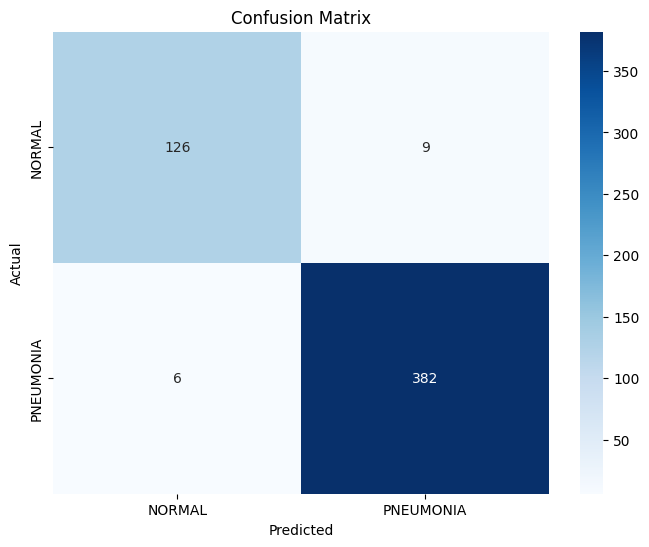

In [32]:
# Generar las predicciones binarias
y_pred_binary = (y_pred > 0.4).astype(int)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_binary)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

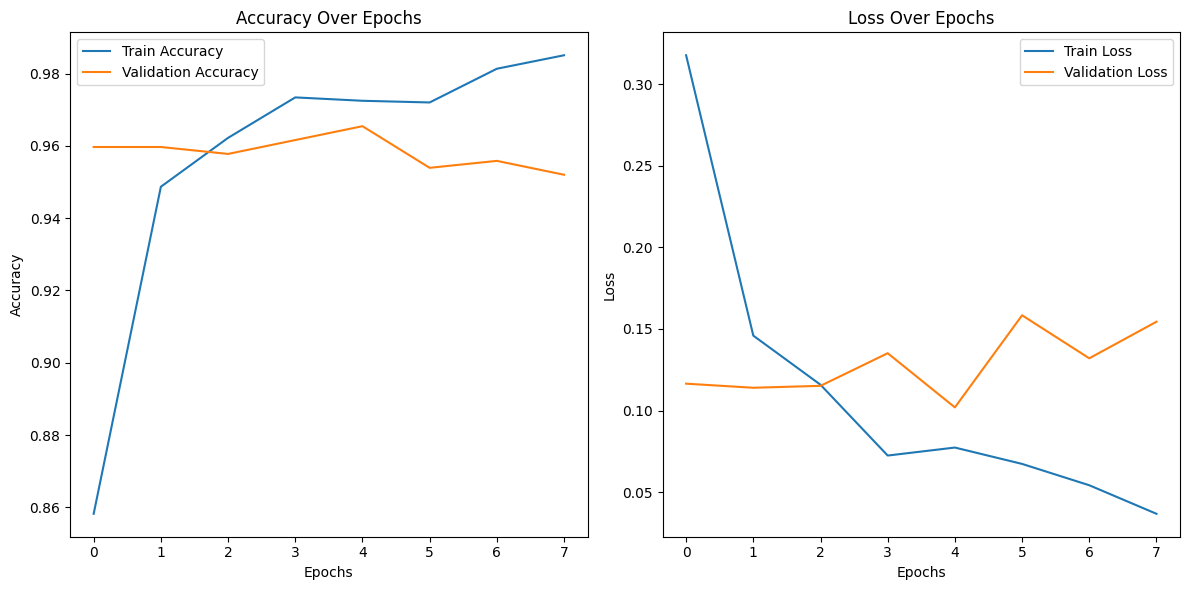

In [33]:
# Visualizar las curvas de precisión
plt.figure(figsize=(12, 6))

# Curva de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Curva de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# Guardar modelo en diccionario para comparación
modelos = {}

# Guardar en el diccionario
modelos["CNN"] = {
    "modelo": cnn_model,
    "historial": cnn_model.history.history,  # Guardar la historia del entrenamiento
    "evaluacion": cnn_model.evaluate(test_generator, verbose=0)  # Evaluar en test
}


In [35]:
# Liberar la memoria de TensorFlow después del entrenamiento
from tensorflow.keras.backend import clear_session
clear_session()

**Hallazgos**

Nuestro modelo tenía 4,828,481 parámetros entrenables.
Después de ejecutar 12 ciclos, pudimos lograr una fiabilidad (accuracy) de entrenamiento de ~95 % y una fiabilidad (accuracy) de prueba de ~72 %.
Incluso después de usar el aumento de datos, la normalización por lotes y las capas de abandono, el modelo parece tener un gran ajuste en el conjunto de datos de entrenamiento y tiene un rendimiento algo bajo.

# **Modelo VGG-16**

Ahora, usando la idea de Transfer Learning. Cargaremos una arquitectura preconstruida: VGG16, que se entrenó en el conjunto de datos de ImageNet.

En el entrenamiento de este modelo, se congela capas iniciales y ajusta solo las últimas 6, se agrega capas densas con regularización y normalización para mejorar generalización y se excluye la parte superior del modelo, es decir, las capas densas que originalmente clasificaban en 1000 clases.

In [37]:
# Cargar VGG16 como modelo base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in base_model.layers[:-6]:
    layer.trainable = False

# Modelo Individual
input_layer = Input(shape=(150, 150, 3))
x = base_model(input_layer, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
output_layer = Dense(1, activation='sigmoid', activity_regularizer=l2(0.001))(x)
model_vgg16 = Model(inputs=input_layer, outputs=output_layer)

# Compilación
model_vgg16.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Entrenamiento
history = model_vgg16.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=12,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluación en conjunto de prueba
test_generator = test_datagen.flow_from_directory(
    os.path.join(new_dataset_dir, 'test'),
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

y_pred = model_vgg16.predict(test_generator)
y_true = test_generator.classes
y_pred_binary = (y_pred > 0.5).astype(int)

auc_score = roc_auc_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
kappa = cohen_kappa_score(y_true, y_pred_binary)

print(f'AUC-ROC: {auc_score:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Cohen Kappa: {kappa:.4f}')


Epoch 1/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 32s 411ms/step - accuracy: 0.7124 - auc: 0.7648 - loss: 1.0015 - val_accuracy: 0.9597 - val_auc: 0.9916 - val_loss: 0.4895 - learning_rate: 5.0000e-05
Epoch 2/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 376ms/step - accuracy: 0.9489 - auc: 0.9886 - loss: 0.4719 - val_accuracy: 0.9328 - val_auc: 0.9933 - val_loss: 0.5598 - learning_rate: 5.0000e-05
Epoch 3/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 377ms/step - accuracy: 0.9607 - auc: 0.9911 - loss: 0.4419 - val_accuracy: 0.9750 - val_auc: 0.9973 - val_loss: 0.4228 - learning_rate: 5.0000e-05
Epoch 4/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 374ms/step - accuracy: 0.9748 - auc: 0.9951 - loss: 0.4012 - val_accuracy: 0.9731 - val_auc: 0.9971 - val_loss: 0.4252 - learning_rate: 5.0000e-05
Epoch 5/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 384ms/step - accuracy: 0.9864 - auc: 0.9989 - loss: 0.3543 - val_accuracy: 0.9789 - val_auc: 0.9985 - val_loss: 0.3830 - learning_rate: 5.0000e-05
Epoch 6/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 379ms/step - 

In [40]:
# Resumen del modelo
model_vgg16.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,989,957 (129.66 MB)

 Trainable params: 9,571,329 (36.51 MB)

 Non-trainable params: 5,275,968 (20.13 MB)

 Optimizer params: 19,142,660 (73.02 MB)

In [41]:
# Guardar el modelo VGG16
model_vgg16.save('model_vgg16.h5')

In [42]:
files.download('model_vgg16.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

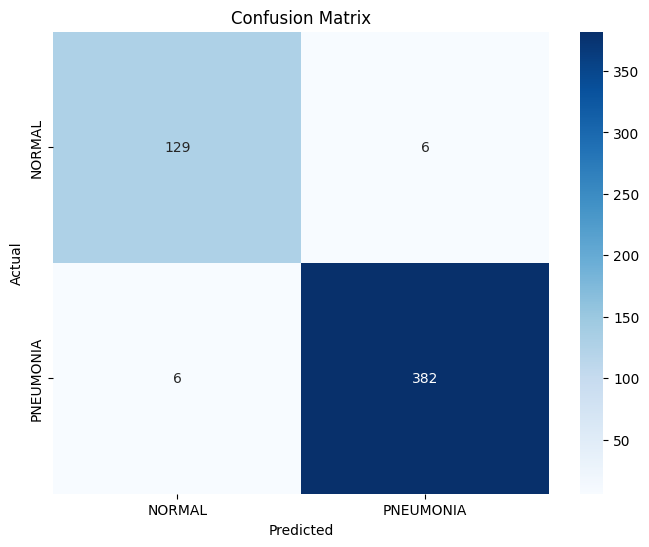

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generar las predicciones binarias
y_pred_binary = (y_pred > 0.3).astype(int)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_binary)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

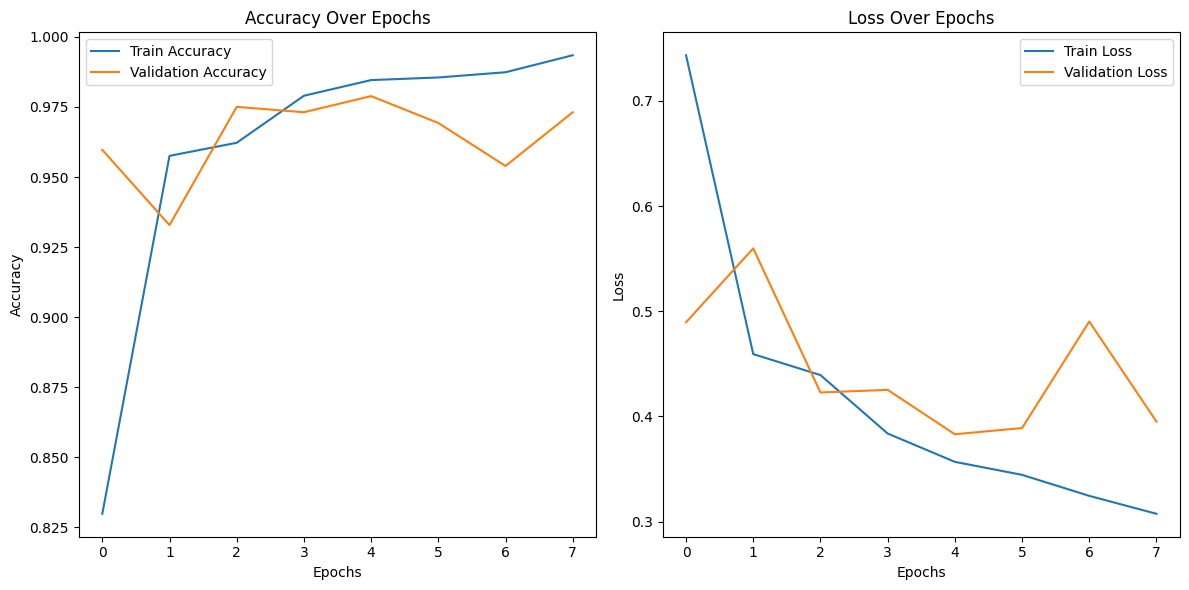

In [44]:
# Visualizar las curvas de precisión
plt.figure(figsize=(12, 6))

# Curva de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Curva de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
# Guardar modelo en diccionario para comparación
modelos["VGG16"] = {
    "modelo": model_vgg16,
    "historial": model_vgg16.history.history,
    "evaluacion": model_vgg16.evaluate(test_generator, verbose=0)
}

In [46]:
# Liberar la memoria de TensorFlow después del entrenamiento
from tensorflow.keras.backend import clear_session
clear_session()

# **InceptionV3 Model**

El modelo toma las imágenes de entrada (preprocesadas y escaladas), extrae características usando InceptionV3 y, con una capa final personalizada, hace una predicción binaria. En el entrenamiento de este modelo se redimensiona imágenes a 299x299 para ser compatibles.


In [47]:
from tensorflow.keras.backend import clear_session

clear_session()  # Limpia la memoria antes de entrenar

In [48]:
# Configuración de los generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    './resampled_dataset/train',
    target_size=(299, 299),  # Tamaño de imagen esperado por InceptionV3
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    './resampled_dataset/val',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    './resampled_dataset/test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

Found 2144 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 523 images belonging to 2 classes.


In [49]:
# Cargar el modelo base de InceptionV3 (preentrenado en ImageNet)
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
# Congelar capas del modelo base para no entrenarlas al inicio
for layer in inception_model.layers:
    layer.trainable = False
# Agregar capas personalizadas encima del modelo base
x = inception_model.output
x = GlobalAveragePooling2D()(x)  # Reducción de dimensiones
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Evitar sobreajuste
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Clasificación binaria (Normal vs Neumonía)
# Crear el modelo final
model = Model(inputs= inception_model.input, outputs=predictions)
# :pushpin: Compilar el modelo
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)
# Resumen del modelo
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,983,457 (87.67 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [60]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Entrenamiento
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    class_weight=class_weights,  # :small_blue_diamond: Usar class_weights_dict_val definido anteriormente
    callbacks=[early_stopping, lr_scheduler]
)

# corregir target_size para que coincida con InceptionV3
test_generator = test_datagen.flow_from_directory(
    os.path.join(new_dataset_dir, 'test'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Usar el modelo actual (model) en lugar de model_vgg16
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_binary = (y_pred > 0.5).astype(int)

auc_score = roc_auc_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
kappa = cohen_kappa_score(y_true, y_pred_binary)

print(f'AUC-ROC: {auc_score:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Cohen Kappa: {kappa:.4f}')

Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 446ms/step - accuracy: 0.9547 - loss: 0.1182 - val_accuracy: 0.9616 - val_loss: 0.1364 - learning_rate: 1.0000e-04
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 435ms/step - accuracy: 0.9530 - loss: 0.1150 - val_accuracy: 0.9155 - val_loss: 0.2434 - learning_rate: 1.0000e-04
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 437ms/step - accuracy: 0.9500 - loss: 0.1288 - val_accuracy: 0.9501 - val_loss: 0.1685 - learning_rate: 1.0000e-04
Epoch 4/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 442ms/step - accuracy: 0.9571 - loss: 0.1048 - val_accuracy: 0.9578 - val_loss: 0.1480 - learning_rate: 1.0000e-04
Epoch 5/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 446ms/step - accuracy: 0.9736 - loss: 0.0779 - val_accuracy: 0.9463 - val_loss: 0.1745 - learning_rate: 5.0000e-05
Found 523 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step
AUC-ROC: 0.9850, F1-score: 0.9491, Precision: 0.9888, Recall: 0.9124, Cohen Kappa: 0.8231


In [61]:
# Guardar el modelo inception
inception_model.save('inception_model.h5')

In [62]:
files.download('inception_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

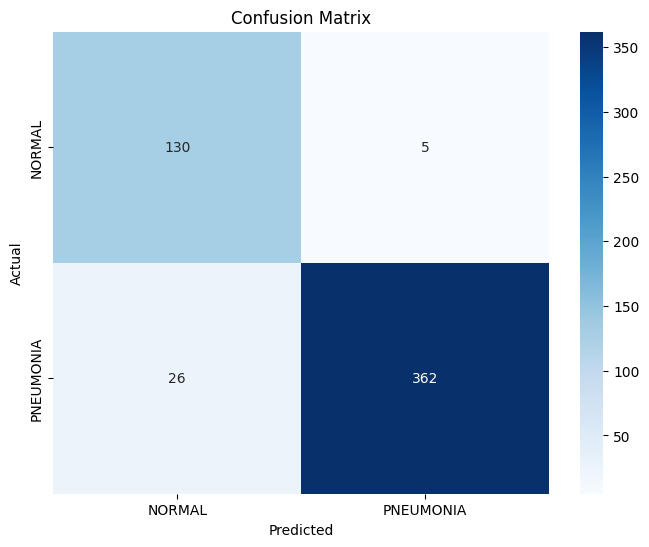

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generar las predicciones binarias
y_pred_binary = (y_pred > 0.3).astype(int)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_binary)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

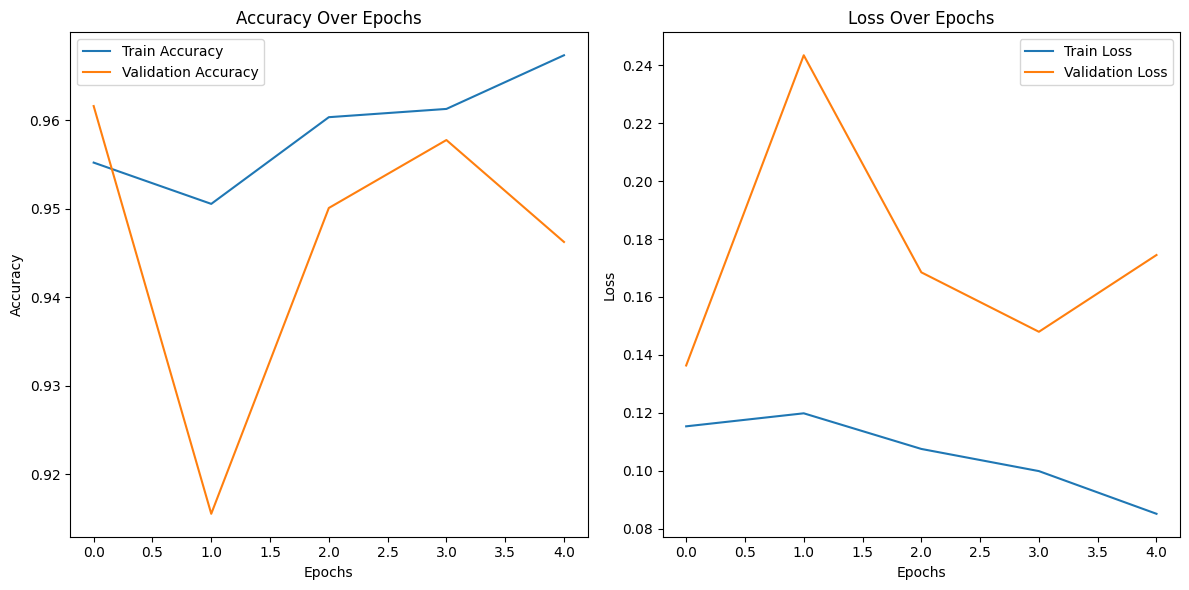

In [64]:
# Visualizar las curvas de precisión
plt.figure(figsize=(12, 6))

# Curva de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Curva de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()